## Code visibility
Use the Show/Hide Code button on the top left to make to make the code visible or hide it. It will be hidden in the HTML files by default.

If a code cell starts with 
```python
# RUN
```
Run the cell by CTRL+Enter, or the Run button above.  

If a code cell starts with
```python
# USER INPUT
```
User input is needed before running the cell, so make sure that the file names and settings included in the cell are appropriate for your run.

If a code cell starts with
```python
# OPTIONAL USER INPUT
```
User input is needed before running the cell. However, some defaults are provided, so make sure that either the settings will work for your run, or change them appropriately.

In [1]:
# RUN
import sys
sys.path.append("/opt/extras/MIPTools/src")
import mip_functions as mip
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import allel
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

Classes reloading.
functions reloading


In [ ]:
# USER INPUT

# provide the MIPWrangler output files
# which must be located in the /opt/data directory within the container.
# if more than one run is to be merged, provide all files
info_files = ["testing_JJJ_DR1_VAR4_20191015.txt.gz"] 

# sample sheets associated with each wrangler file,
# in the same order as the wrangler files.
sample_sheets = ["sample_list.tsv"]

# No input below
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

The above table shows the unique sample_set, probe_set combinations in the sample sheets provided. Select which combinations should be used for this analysis.

If more than one combination is to be used, the input will be a list of lists, for example:
```python
sample_groups = [["sample_set_1", "probe_set_1"], ["sample_set_2", "probe_set_2"]]
```

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. For example,  
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

In [4]:
# USER INPUT
species =  "pf"
probe_sets_used = "IBC"

In [5]:
# OPTIONAL USER INPUT
# available cpu count
processorNumber = 20

## extra bwa options for haplotype alignment
# "-a" for getting all alignments
# "-L 500" to penalize soft clipping 
bwaExtra = ["-t", str(processorNumber)]

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [6]:
# RUN

# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])

# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")

# update bwa settings with processor count
bwaOptions = temp_settings["bwaOptions"]
try:
    bwaOptions.extend(bwaExtra)
except AttributeError:
    bwaOptions = [bwaOptions]
    bwaOptions.extend(bwaExtra)

# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]

# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"processorNumber": processorNumber,
               "bwaOptions": bwaOptions,
               "species": species,
               "mipSetKey" : mipSetKey}
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

# 1) Process run data
First section of the data analysis involves processing the MIPWrangler output files, combining data from multiple runs (if necessary), mapping haplotypes and creating summary files and plots showing how the sequencing runs went.

### MIPWrangler output file processing
Below operation combines output files from multiple runs, summing up count data belonging to the same libraries.  

Libraries are labeled by combining three fields in the sample sheet: sample_name-sample_set-replicate, which makes the Sample ID. If two different libraries has the same Sample ID (same three fields, but a different LibraryPrep identifier), the overlapping libraries will be assigned new replicate numbers such that there are no shared IDs any more. A warning will be printed in that case, and the original sample ID and the new one will be written to the samples.tsv file generated in the analysis directory.

If only a single output file is used, then the below operation just filters and renames some columns from the original file.

In [ ]:
# RUN
if len(info_files) > 1:
    mip.combine_info_files(wdir,
                           settings_file, 
                           info_files,
                           sample_sheets,
                           settings["mipsterFile"],
                           sample_sets=sample_groups)
else:
    mip.process_info_file(wdir,
                          settings_file, 
                          info_files,
                          sample_sheets,
                          settings["mipsterFile"],
                          sample_sets=sample_groups)

### Filter and map haplotype sequences
Align each haplotype sequence to the reference genome. Remove off target haplotypes. All haplotype mappings will be saved to the disk so off targets can be inspected if needed. 

Some filters can be applied to remove noise:
*  minHaplotypeBarcodes: minimum total UMI cut off across all samples.
*  minHaplotypeSamples: minimum number of samples a haplotype is observed in.
*  minHaplotypeSampleFraction: minimum fraction of samples a haplotype is observed in.  

It is probably safe to apply minimal count filters like at least 10 UMIs across samples and at least two samples. However, most data sets will be easily handled without these filters. So it may be better to not filter at this step unless the downstream operations are taking too much resources. However, filters can and should be applied after variant calls are made.

In [7]:
# OPTIONAL USER INPUT
settings["minHaplotypeBarcodes"] = 1 # set to 10 if it is taking > 12 h to get variant calls.
settings["minHaplotypeSamples"] = 1 # do not set to higher values unless you must
settings["minHaplotypeSampleFraction"] = 0.0001 # this value will filter haplotype sequences that are observed
################################################# in less than 1 sample in 10000 samples.

In [8]:
#RUN
mip.get_vcf_haplotypes(settings)
mip.get_haplotype_counts(settings)

Out of 12436 initial haplotypes, 0 were filtered using 1, 1, and 0.0001 as minimum total UMI count; number and fraction of samples  the haplotype was observed in, respectively.
327 of 12436 haplotypes were off-target, either not mapping to the reference genome, or best mapping to a region which was not targeted.
Total number of reads and barcodes were 7459272 and 3188942. On target number of reads and barcodes were 7455352 and 3187315.
There are 63 samples with sequence data
There are 63 total samples.
0 out of 63 samples had no data and they were excluded from the variant calls.


### Preview the mapping results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb63c7e9ba8>)

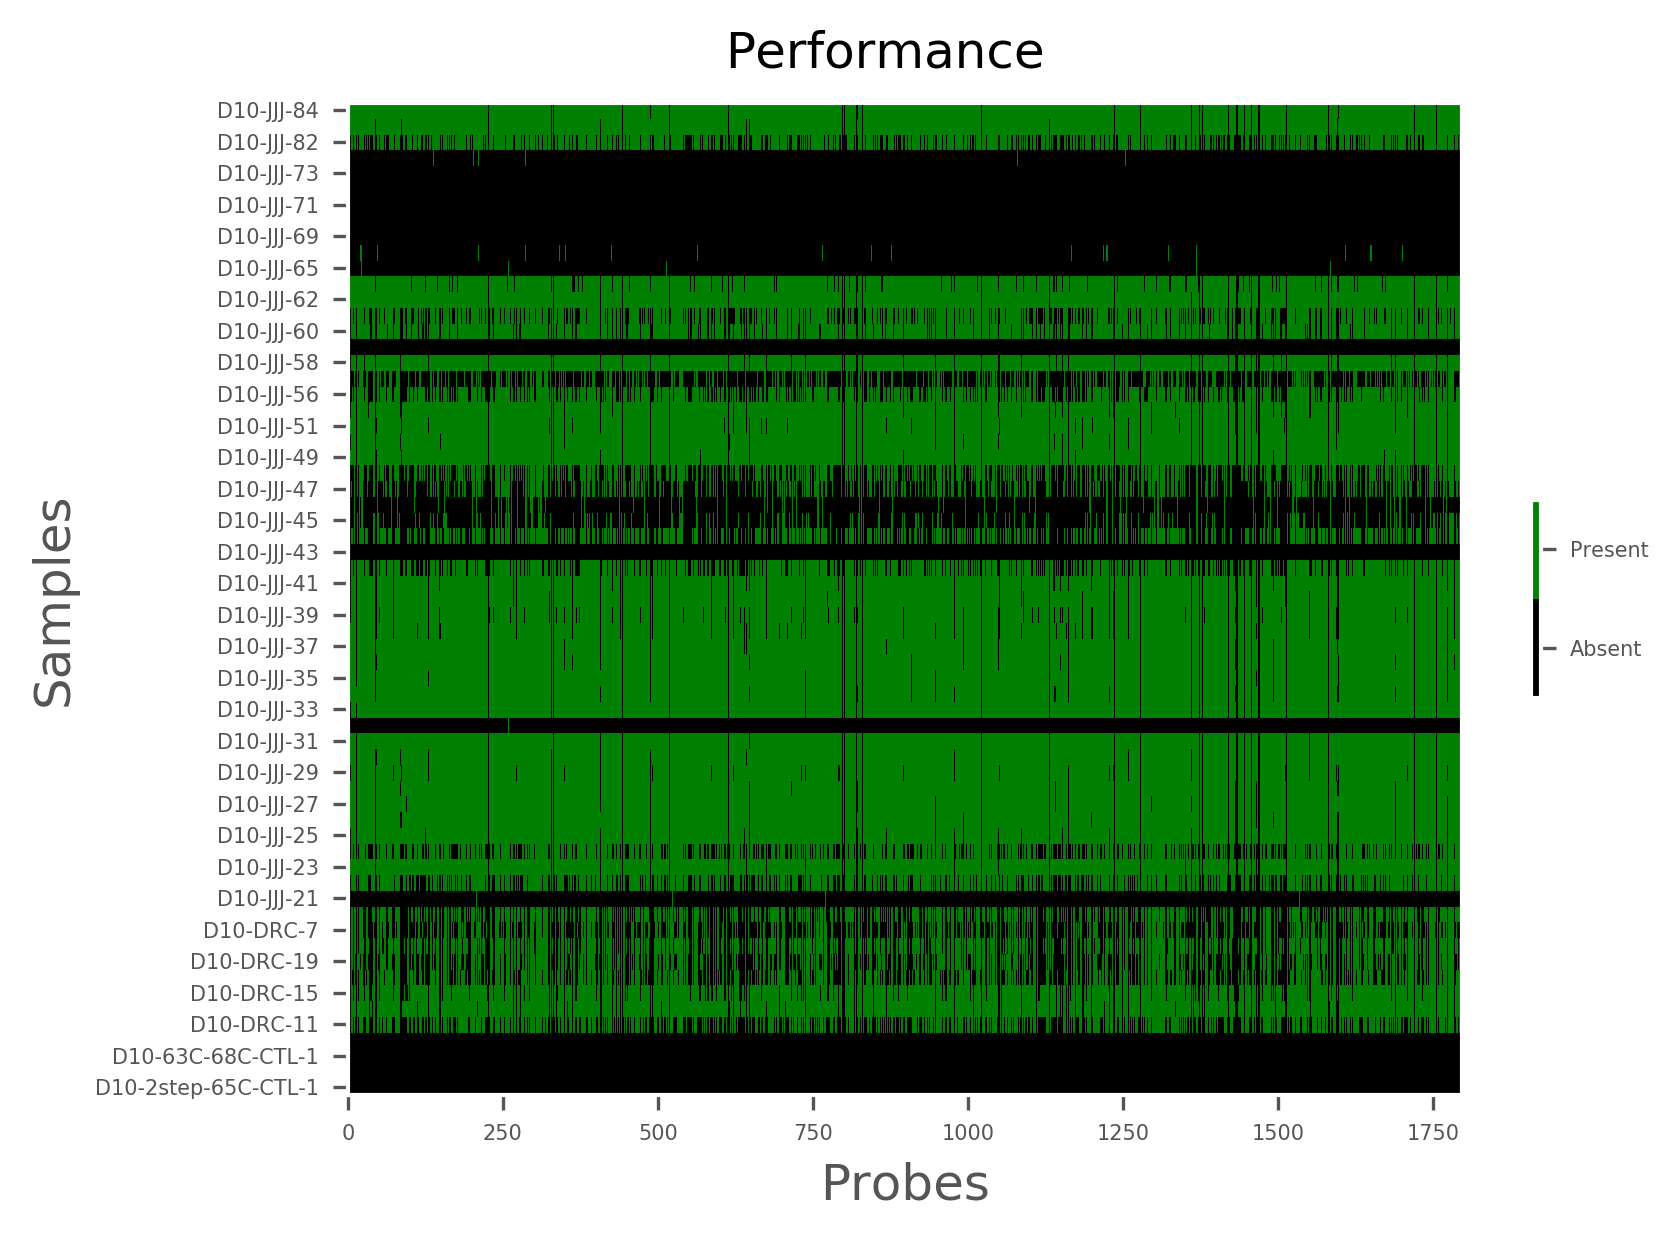

In [9]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=10, # anything below this number will be considered absent
                     tick_label_size=5, # font size for tick labels for x and y axis
                     cbar_label_size=5, # font size for heat map color bar
                     dpi=300, # figure resolution
                     absent_color='black',
                     present_color='green',
                     save=False, # If false, plots the graph here. If true, saves a .png in the analysis dir
                    ytick_freq=None, # How frequent the y-axis ticks should be (every nth column will have  a tick)
                    xtick_freq=None,
                    xtick_rotation=90) # x-axis tick label rotation 

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [10]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,D10-2step-65C-CTL-1,106.0,105.0,99,0,0
1,D10-2step-65C-CTL-2,87.0,84.0,79,0,0
2,D10-63C-68C-CTL-1,49.0,49.0,48,0,0
3,D10-63C-68C-CTL-2,42.0,42.0,41,0,0
4,D10-DRC-11,68209.0,24585.0,1734,1429,1016


### Plot total barcode count vs probe coverage
A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

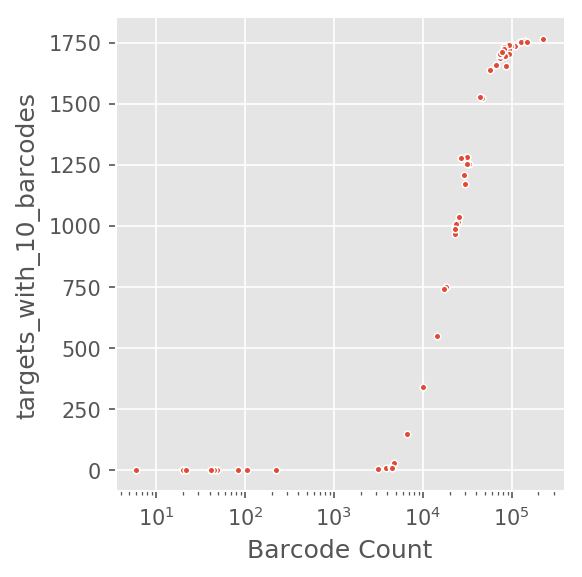

In [11]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **50 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 50
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

In [12]:
# USER INPUT
high_barcode_threshold = 100000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
barcode_coverage_threshold=10
barcode_count_threshold=100
low_coverage_action='Recapture'
assesment_key='targets_with_1_barcodes'
good_coverage_quantile=0.25

In [13]:
# RUN
meta = pd.read_csv(wdir + "merged_meta.csv")
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 63 samples 24 are completed, 9 will be recaptured and 30 repooled
5 samples showed uneven coverage, 0 complete, 0 to be recaptured, 5 repooled


# 2) Variant Calling
Second part of the analysis involves variant calling and variant analysis. 

### Options for freebayes wrapper
```Python
align = True # Default is set to true, fastq files and bam files per sample
# will be created in 'fastq_dir' and 'bam_dir'. 
# it should be set to false if bam files are available.

settings = settings # analysis settings dictionary created above.

bam_files = None # default is to use all bam files within the bam_dir.
# if specific files should be used, then they can be specified in a list.

verbose = True # prints errors and warnings as well as saving to disk.
# if set to false, it will print that there is an error which will
# be saved to disk which should be inspected for details.

targets_file = None # force calls on specific loci even if there is
# no observations satisfying filter criteria. Useful in cases of targeted
# mutations such as drug resistance mutations.
# Usually a file at "/opt/project_resources/targets.tsv" would be present
# if the project requires it. Then targets_file should be set to this path.

# paths for input-output files with default values that can be left unchanged
fastq_dir, bam_dir, vcf_file, settings_file, errors_file, warnings_file

# additional options to pass to freebayes directly:
options = [] # see below for suggestions and possibilities.
```
#### Additional options for freebayes caller. 
Most of the freebayes options are shown below in the **freebayes help** section at the bottom of this document. Some options are integrated into the python wrapper freebayes_call, but others should be added depending on the data type, species etc.

integrated options:
```bash
    -r region
            limit calls to a specific region. 
            This is done internally, splitting the results into contigs and processing each contig
            separately (in parallel if multiple cpus are available).
            Per-contig vcf files are concatenated at the end into a single file.
    -@ targets.vcf
            force calls on positions provided in the vcf file
            a vcf file is generated if a tab separated file containing targets are provided.
    -L --bam-list
            a list of bam files to be used. By default, all bams in bams directory will be used.
            A list of specific bams can be specified to freebayes_call as bam_files option.
```
options to consider adding for parasite sequencing:
```bash
    --pooled-continuous
             This option does not make assumptions about the ploidy when making genotype calls.
             It makes sense for a mixed ploidy sample such as parasite infected blood DNA.
             variants are still called as diploid. 
    --min-alternate-fraction 0.01
             since we assume a pooled continuous sample, it would be better to set a within
             samlpe allele frequency threshold to remove noise. 
             this is likely not needed when dealing with a diploid sample because a frequency 
             of 0.01 will likely be considered noise for a diploid sample.
    --min-alternate-count 2
             number of reads supporting a variant to consider for genotype calls.
             having this at at least 2 is good. It will be possible to process
             variants with 1 reads in postprocessing steps if a specific variant
             is observed at least in one sample at > 1 reads. So this removes the 
             variant from consideration if no sample has > 1 reads supporting it.
    --min-alternate-total 10
             total read support for a variant across samples.
```
options to consider for human sequences:
```bash
    --min-mapping-quality 0
             default for this setting is 1. I do not think this is helping much in 
             addressing mapping issues. However, reads in copy number variant regions
             may have 0 mapping quality. These would be worth to keep, but they
             should be handled appropriately at postprocessing steps.
    --min-alternate-count 2
    --min-alternate-fraction 0.05 (default)
    --min-alternate-total 10
```

In [15]:
# USER INPUT
r = mip.freebayes_call(settings=settings,
                       options=["--pooled-continuous",
                                "--min-alternate-fraction", "0.01",
                                "--min-alternate-count", "2",
                                "--min-alternate-total", "10"],
                       align=True, verbose=True,
                       fastq_dir="/opt/analysis/padded_fastqs",
                       bam_dir="/opt/analysis/padded_bams",
                       vcf_file="/opt/analysis/variants.vcf.gz",
                       targets_file="/opt/project_resources/targets.tsv",
                       bam_files=None,
                       errors_file="/opt/analysis/freebayes_errors.txt",
                       warnings_file="/opt/analysis/freebayes_warnings.txt")

### Postprocessing of called variants
Freebayes produces high quality vcf files with haplotype based variant calls. This is important for getting more accurate calls, especially for complex regions where SNVs may overlap with indels and there may be many possible alleles as opposed to a simple biallelic SNV call.

However, it may be desired to "decompose" these complex variants for some applications. For example, if we are interested in knowing the prevalence of a specific drug resistance mutation, it would make sense to combine all variants containing this mutation even though they may be part of different haplotypes, and hence are represented in the vcf in different variants.

vcf_to_tables function takes the vcf file generated by freebayes and generates allele count and coverage data in table form. It is possible to decompose and aggregate amino acid and/or nucleotide level variants. 3 files containing count data are generated: alternate_table.csv, reference_table.csv, coverage_table.csv, for alt allele, ref allele and coverage count values for each variant, respectively.

It first separates the multiallelic calls to bi-allelic calls.

#### annotate, default=True
It then annotates variants using snpEff.

#### geneid_to_genename, default=None
Variant annotation provides a gene ID (e.g. PF3D7_0709000) but it does not provide common gene names (e.g. crt). If common names are used in target files, or they are desired in general, a tab separated gene ID to gene name file can be used. **gene_name and gene_id** columns are required. If no file is provided, gene name will be the same as the gene ID.

#### aggregate_aminoacids, default=False
If aminoacid level aggregation is requested, it decomposes multi amino acid missense variants into single components and aggregates the alternate allele and coverage counts per amino acid change. For example, Asn75Glu change for crt gene is a known drug resistance mutation in Plasmodium falciparum. There may be 3 separate variants in the vcf file that contain this mutation: Asn75Glu, MetAsn75IleGlu, Asn75Glu_del76-80*. All three has the missense variant Asn75Glu. While the first two  are simple changes, the third is a complex change including a 5 amino acid deletion and a stop codon following Asn75Glu. In this case, it makes sense to combine the counts of the first two variants towards Asn75Glu counts but the third one is debatable because of the complexity; i.e. the drug resistance mutation Asn75Glu probably is not that improtant in that context because of the stop codon following it. So we decompose the simple changes and aggregate but leave complex changes as they are. If aminoacid aggregation is carried out, file names will contain AA tag.

#### target_aa_annotation, default=None
It is also possible to annotate the targeted variants (such as Asn75Glu above) in the generated tables as 'Targeted' in case some analysis should be carried out on targeted variants only. A tab separated file containing the annotation details is required for this operation. **gene_name, aminoacid_change and mutation_name** are required fields. If a variants gene_name and aminoacid_change are matching to a row in the target file, that variant will be marked as targeted and will have the correspondign mutation name. Note that if common gene name conversion (see above) is not used, the gene_name column in this file must match the actual gene ID and not the common name. It may be more convenient to keep the gene IDs in the target file as well and use that file for ID to name mapping. **aggregate_aminoacids must be set to True** for this option to be used.

#### aggregate_nucleotides, default=False
A similar aggregation can be done at nucleotide level. If specified, biallelic variants will be decomposed using the tool **vt decompose_blocksub**. By default it decomposes block substitutions that do not include indels. However, it is also possible to decompose complex variants including indels by providing -a option. For possible decompose options see vt help:
```bash
vt decompose_blocksub options : 
  -p  Output phased genotypes and PS tags for decomposed variants [false]
  -m  keep MNVs (multi-nucleotide variants) [false]
  -a  enable aggressive/alignment mode [false]
  -d  MNVs max distance (when -m option is used) [2]
  -o  output VCF file [-]
  -I  file containing list of intervals []
  -i  intervals []
  -?  displays help
```
If nucleotide level aggregation is done, the file names will include AN tag.

#### target_nt_annotation, default=None
Annotation of targeted nucleotides requires a file similar to the targeted amino acid annotation. However, the required fields for this annotation are: CHROM, POS, REF, ALT and mutation_name. **aggregate_nucleotides must be set to True** for this option to be used.

#### aggregate_none, default=True
It is also possible to generate count tables without doing any aggregation. This will generate the 3 count files, and all of the variant information included in the vcf file will be a separate column in the table's index. For annotated initial vcf files, or if annotate option is selected, each subfield in the INFO/ANN field will have its own column.

In [22]:
from autoreload import reload
reload(mip)

functions reloading


<module 'mip_functions' from '/opt/extras/MIPTools/src/mip_functions.py'>

In [29]:
# USER INPUT
mip.vcf_to_tables("variants.vcf.gz", # input vcf (output of freebayes_call function)
                  settings=settings, # analysis settings dictionary
                  settings_file=None, # provide the path to the settings file if settings dictionary has not been loaded
                  annotate=True, # use snpEff to annotate the variants
                  geneid_to_genename=None,
                  target_aa_annotation=None, # no amino acid changes will be annotated as targeted in the tables.
                  aggregate_aminoacids=True, # multi amino acid changes will be decomposed and combined
                  target_nt_annotation="/opt/project_resources/targets.tsv", # targeted nucleotide changes will be annotated as targeted
                  aggregate_nucleotides=True, # MNVs will be decomposed and resulting SNV counts will be combined
                  decompose_options=[], # default vt options will be used for decomposing nucleotides. Supply ["-a"] to include indels in decomposition, or other options shown above if desired.
                  annotated_vcf=False, # initial vcf file was not annotated by snpEff
                  aggregate_none=True) # tables for variants as they are in the vcf file will be generated. Multiallelic variants will be split into biallelic.

### Amino acid changes (aggregated)
For some projects we may be interested in the amino acid changes, particularly specific, targeted amino acid changes, such as drug resistance mutations in *Plasmodium falciparum*, which is the data set provided for pipeline test. For these type of projects, we may want to analyze the variants from the amino acid perspective, rather than nucleotide changes which is standard output for variant callers.  

**alternate_AA_table.csv** file in the analysis directory is created if aggregate_aminoacids option was selected when creating data tables. This table has the UMI counts for each alternate amino acid.  

**coverage_AA_table.csv** file is the corresponding coverage depth for each variant's position.

Below we'll load these two tables and see how they can be used.



In [30]:
# USER INPUT
mutation_counts = pd.read_csv("/opt/analysis/alternate_AN_table.csv",
                             header=list(range(6)),
                            index_col=0)
mutation_counts.head()

CHROM                    chr1                                      \
POS                    100491            100608            138823   
REF                         T                 A                 C   
ALT                         C                 G                 T   
Mutation Name chr1:100491:T:C chr1:100608:.:A:G chr1:138823:.:C:T   
Targeted                   No               Yes               Yes   
D10-DRC-17                  0                 0                 0   
D10-JJJ-64                  0                 0                 0   
D10-DRC-11                  0                 0                 0   
D10-JJJ-62                  1                 0                 0   
D10-JJJ-41                  0                 2                 0   

CHROM                                                             \
POS                      139191                           139192   
REF                           C               CC               C   
ALT                           T                T               T   
Mutation Name chr1:139191:.:C:T chr1:139191:CC:T chr1:139192:C:T   
Targeted                    Yes               No              No   
D10-DRC-17                    8                0               2   
D10-JJJ-64                    0                0               0   
D10-DRC-11                    5                0               0   
D10-JJJ-62                   61                0              26   
D10-JJJ-41                   22                0               7   

CHROM                                                              \
POS                      140820            155939          155977   
REF                           A                 G               G   
ALT                           C                 A               A   
Mutation Name chr1:140820:.:A:C chr1:155939:.:G:A chr1:155977:G:A   
Targeted                    Yes               Yes              No   
D10-DRC-17                    0                 7               5   
D10-JJJ-64                    0                 0               0   
D10-DRC-11                    5                 8              11   
D10-JJJ-62                   16                33              28   
D10-JJJ-41                    6                12              12   

CHROM                                  ...                       chr9  \
POS                      155978        ...                    1406587   
REF                           C        ...                          G   
ALT                           T        ...                          A   
Mutation Name chr1:155978:.:C:T        ...         chr9:1406587:.:G:A   
Targeted                    Yes        ...                        Yes   
D10-DRC-17                    5        ...                          0   
D10-JJJ-64                    0        ...                          0   
D10-DRC-11                   11        ...                          3   
D10-JJJ-62                   28        ...                         20   
D10-JJJ-41                   12        ...                          6   

CHROM                                                                 \
POS                    1406631            1418176            1418612   
REF                          T                  A                  G   
ALT                          C                  G                  C   
Mutation Name chr9:1406631:T:C chr9:1418176:.:A:G chr9:1418612:.:G:C   
Targeted                    No                Yes                Yes   
D10-DRC-17                   3                  4                  0   
D10-JJJ-64                   0                  0                  0   
D10-DRC-11                   7                  3                  2   
D10-JJJ-62                  47                 51                  5   
D10-JJJ-41                  17                 17                  0   

CHROM                                                                 \
POS                      1419331            1422363          1

In [31]:
# USER INPUT
mutation_coverage = pd.read_csv("/opt/analysis/coverage_AN_table.csv",
                           index_col=0, header=list(range(6)))
mutation_coverage.head()

CHROM                    chr1                                      \
POS                    100491            100608            138823   
REF                         T                 A                 C   
ALT                         C                 G                 T   
Mutation Name chr1:100491:T:C chr1:100608:.:A:G chr1:138823:.:C:T   
Targeted                   No               Yes               Yes   
D10-DRC-17                  0                 1                 9   
D10-JJJ-64                  0                 0                 0   
D10-DRC-11                  0                 0                11   
D10-JJJ-62                  1                14                94   
D10-JJJ-41                  0                10                34   

CHROM                                                             \
POS                      139191                           139192   
REF                           C               CC               C   
ALT                           T                T               T   
Mutation Name chr1:139191:.:C:T chr1:139191:CC:T chr1:139192:C:T   
Targeted                    Yes               No              No   
D10-DRC-17                   26               26              26   
D10-JJJ-64                    0                0               0   
D10-DRC-11                   12               12              12   
D10-JJJ-62                  182              182             182   
D10-JJJ-41                   64               64              64   

CHROM                                                              \
POS                      140820            155939          155977   
REF                           A                 G               G   
ALT                           C                 A               A   
Mutation Name chr1:140820:.:A:C chr1:155939:.:G:A chr1:155977:G:A   
Targeted                    Yes               Yes              No   
D10-DRC-17                   43                25              25   
D10-JJJ-64                    0                 0               0   
D10-DRC-11                   43                34              34   
D10-JJJ-62                  336               147             147   
D10-JJJ-41                  138                55              55   

CHROM                                  ...                       chr9  \
POS                      155978        ...                    1406587   
REF                           C        ...                          G   
ALT                           T        ...                          A   
Mutation Name chr1:155978:.:C:T        ...         chr9:1406587:.:G:A   
Targeted                    Yes        ...                        Yes   
D10-DRC-17                   25        ...                         19   
D10-JJJ-64                    0        ...                          0   
D10-DRC-11                   34        ...                         19   
D10-JJJ-62                  147        ...                        169   
D10-JJJ-41                   55        ...                         59   

CHROM                                                                 \
POS                    1406631            1418176            1418612   
REF                          T                  A                  G   
ALT                          C                  G                  C   
Mutation Name chr9:1406631:T:C chr9:1418176:.:A:G chr9:1418612:.:G:C   
Targeted                    No                Yes                Yes   
D10-DRC-17                  19                 14                 19   
D10-JJJ-64                   0                  0                  0   
D10-DRC-11                  19                 14                 17   
D10-JJJ-62                 169                155                119   
D10-JJJ-41                  59                 56                 56   

CHROM                                                                 \
POS                      1419331            1422363          1

**Genotypes** for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.
```Python
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
geno = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                     else 0 if x < min_freq
                     else 1 if x < (1 - min_freq)
                     else 2)
```

A genotypes.csv file is already generated using the cut off values provided in the settings file.

In [ ]:
# USER INPUT
min_count = 2
min_coverage = 10
min_freq = 0.01
# filter mutation counts for minimum count parameter by setting counts to zero if it is below threshold
mutation_counts = mutation_counts.applymap(lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting coverage to zero if it is below threshold
mutation_coverage = mutation_coverage.applymap(lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = mutation_counts / mutation_coverage
# call genotypes using the minimum within sample allele frequency parameter from the settings file
genotypes = freq.applymap(lambda x: np.nan if (np.isnan(x) or np.isinf(x))
                 else 0 if x < min_freq
                 else 1 if x < (1 - min_freq)
                 else 2)

### How well have we been able to genotype the targeted mutation loci?
Limiting the genotypes to the targeted loci.

In [ ]:
# RUN
targeted_mutations = genotypes.xs("Yes", level="Targeted", axis=1)
targeted_mutations.head()

### Get the percentage of samples successfully genotyped at target loci for each mutation

In [ ]:
# RUN
targeted_mutations.count()*100/targeted_mutations.shape[0]

### Calculate prevalence data from the genotype data

In [ ]:
# RUN
targeted_prevalences = targeted_mutations.applymap(lambda x: 1 if x in [1, 2] else 0 if x == 0 else np.nan)
targeted_prevalences.head()

### Look at the average prevalence of each mutation across the population

In [ ]:
# RUN
targeted_prevalences.sum()/targeted_prevalences.count()

### Other files
alternate_AN_table.csv and alternate_table.csv files as well as their corresponding coverage table files are also located in the analysis directory (if aggregate_nucleotides or aggregate_none options were used in table generation. 

## freebayes help
Below are the various sections of freebayes --help output showing examples and options.
```bash
citation: Erik Garrison, Gabor Marth
          "Haplotype-based variant detection from short-read sequencing"
          arXiv:1207.3907 (http://arxiv.org/abs/1207.3907)

author:   Erik Garrison <erik.garrison@bc.edu>, Marth Lab, Boston College, 2010-2014
version:  v1.3.1-dirty
```


### overview:
```bash
    To call variants from aligned short-read sequencing data, supply BAM files and
    a reference.  FreeBayes will provide VCF output on standard out describing SNPs,
    indels, and complex variants in samples in the input alignments.

    By default, FreeBayes will consider variants supported by at least 2
    observations in a single sample (-C) and also by at least 20% of the reads from
    a single sample (-F).  These settings are suitable to low to high depth
    sequencing in haploid and diploid samples, but users working with polyploid or
    pooled samples may wish to adjust them depending on the characteristics of
    their sequencing data.

    FreeBayes is capable of calling variant haplotypes shorter than a read length
    where multiple polymorphisms segregate on the same read.  The maximum distance
    between polymorphisms phased in this way is determined by the
    --max-complex-gap, which defaults to 3bp.  In practice, this can comfortably be
    set to half the read length.

    Ploidy may be set to any level (-p), but by default all samples are assumed to
    be diploid.  FreeBayes can model per-sample and per-region variation in
    copy-number (-A) using a copy-number variation map.

    FreeBayes can act as a frequency-based pooled caller and describe variants
    and haplotypes in terms of observation frequency rather than called genotypes.
    To do so, use --pooled-continuous and set input filters to a suitable level.
    Allele observation counts will be described by AO and RO fields in the VCF output.

```

### examples:
```bash
    # call variants assuming a diploid sample
    freebayes -f ref.fa aln.bam >var.vcf

    # call variants assuming a diploid sample, providing gVCF output
    freebayes -f ref.fa --gvcf aln.bam >var.gvcf

    # require at least 5 supporting observations to consider a variant
    freebayes -f ref.fa -C 5 aln.bam >var.vcf

    # discard alignments overlapping positions where total read depth is greater than 200
    freebayes -f ref.fa -g 200 aln.bam >var.vcf

    # use a different ploidy
    freebayes -f ref.fa -p 4 aln.bam >var.vcf

    # assume a pooled sample with a known number of genome copies
    freebayes -f ref.fa -p 20 --pooled-discrete aln.bam >var.vcf

    # generate frequency-based calls for all variants passing input thresholds
    freebayes -f ref.fa -F 0.01 -C 1 --pooled-continuous aln.bam >var.vcf

    # use an input VCF (bgzipped + tabix indexed) to force calls at particular alleles
    freebayes -f ref.fa -@ in.vcf.gz aln.bam >var.vcf

    # generate long haplotype calls over known variants
    freebayes -f ref.fa --haplotype-basis-alleles in.vcf.gz \
                        --haplotype-length 50 aln.bam

    # naive variant calling: simply annotate observation counts of SNPs and indels
    freebayes -f ref.fa --haplotype-length 0 --min-alternate-count 1 \
        --min-alternate-fraction 0 --pooled-continuous --report-monomorphic >var.vcf
```

### input:
```bash
   -b --bam FILE   Add FILE to the set of BAM files to be analyzed.
   -L --bam-list FILE
                   A file containing a list of BAM files to be analyzed.
   -c --stdin      Read BAM input on stdin.  
   -f --fasta-reference FILE
                   Use FILE as the reference sequence for analysis.
                   An index file (FILE.fai) will be created if none exists.
                   If neither --targets nor --region are specified, FreeBayes
                   will analyze every position in this reference.
   -t --targets FILE
                   Limit analysis to targets listed in the BED-format FILE.
   -r --region <chrom>:<start_position>-<end_position>
                   Limit analysis to the specified region, 0-base coordinates,
                   end_position not included (same as BED format).
                   Either '-' or '..' maybe used as a separator.
   -s --samples FILE
                   Limit analysis to samples listed (one per line) in the FILE.
                   By default FreeBayes will analyze all samples in its input
                   BAM files.
   --populations FILE
                   Each line of FILE should list a sample and a population which
                   it is part of.  The population-based bayesian inference model
                   will then be partitioned on the basis of the populations.
   -A --cnv-map FILE
                   Read a copy number map from the BED file FILE, which has
                   either a sample-level ploidy:
                      sample_name copy_number
                   or a region-specific format:
                      seq_name start end sample_name copy_number
                   ... for each region in each sample which does not have the
                   default copy number as set by --ploidy. These fields can be delimited
                   by space or tab.

```

### output:
```bash
   -v --vcf FILE   Output VCF-format results to FILE. (default: stdout)
   --gvcf
                   Write gVCF output, which indicates coverage in uncalled regions.
   --gvcf-chunk NUM
                   When writing gVCF output emit a record for every NUM bases.
   -& --gvcf-dont-use-chunk BOOL
                   When writing the gVCF output emit a record for all bases if
                   set to "true" , will also route an int to --gvcf-chunk
                   similar to --output-mode EMIT_ALL_SITES from GATK
   -@ --variant-input VCF
                   Use variants reported in VCF file as input to the algorithm.
                   Variants in this file will included in the output even if
                   there is not enough support in the data to pass input filters.
   -l --only-use-input-alleles
                   Only provide variant calls and genotype likelihoods for sites
                   and alleles which are provided in the VCF input, and provide
                   output in the VCF for all input alleles, not just those which
                   have support in the data. 
   --haplotype-basis-alleles VCF
                   When specified, only variant alleles provided in this input
                   VCF will be used for the construction of complex or haplotype
                   alleles.
   --report-all-haplotype-alleles
                   At sites where genotypes are made over haplotype alleles,
                   provide information about all alleles in output, not only
                   those which are called.   
   --report-monomorphic
                   Report even loci which appear to be monomorphic, and report all
                   considered alleles, even those which are not in called genotypes.
                   Loci which do not have any potential alternates have '.' for ALT.
   -P --pvar N     Report sites if the probability that there is a polymorphism
                   at the site is greater than N.  default: 0.0.  Note that post-
                   filtering is generally recommended over the use of this parameter.
   --strict-vcf
                   Generate strict VCF format (FORMAT/GQ will be an int)

```

### population model:
```bash
-T --theta N    The expected mutation rate or pairwise nucleotide diversity
                   among the population under analysis.  This serves as the
                   single parameter to the Ewens Sampling Formula prior model
                   default: 0.001
   -p --ploidy N   Sets the default ploidy for the analysis to N.  default: 2
   -J --pooled-discrete
                   Assume that samples result from pooled sequencing.
                   Model pooled samples using discrete genotypes across pools.
                   When using this flag, set --ploidy to the number of
                   alleles in each sample or use the --cnv-map to define
                   per-sample ploidy.
   -K --pooled-continuous
                   Output all alleles which pass input filters, regardles of
                   genotyping outcome or model.
```
### reference allele:
```bash
   -Z --use-reference-allele
                   This flag includes the reference allele in the analysis as
                   if it is another sample from the same population.
   --reference-quality MQ,BQ
                   Assign mapping quality of MQ to the reference allele at each
                   site and base quality of BQ.  default: 100,60
```
### allele scope:
```bash
   -n --use-best-n-alleles N
                   Evaluate only the best N SNP alleles, ranked by sum of
                   supporting quality scores.  (Set to 0 to use all; default: all)
   -E --max-complex-gap N
      --haplotype-length N
                   Allow haplotype calls with contiguous embedded matches of up
                   to this length. Set N=-1 to disable clumping. (default: 3)
   --min-repeat-size N
                   When assembling observations across repeats, require the total repeat
                   length at least this many bp.  (default: 5)
   --min-repeat-entropy N
                   To detect interrupted repeats, build across sequence until it has
                   entropy > N bits per bp. Set to 0 to turn off. (default: 1)
   --no-partial-observations
                   Exclude observations which do not fully span the dynamically-determined
                   detection window.  (default, use all observations, dividing partial
                   support across matching haplotypes when generating haplotypes.)

  These flags are meant for testing.
  They are not meant for filtering the output.
  They actually filter the input to the algorithm by throwing away alignments.
  This hurts performance by hiding information from the Bayesian model.
  Do not use them unless you can validate that they improve results!

   -I --throw-away-snp-obs     Remove SNP observations from input.
   -i --throw-away-indels-obs  Remove indel observations from input.
   -X --throw-away-mnp-obs     Remove MNP observations from input.
   -u --throw-away-complex-obs Remove complex allele observations from input.

  If you need to break apart haplotype calls to obtain one class of alleles,
  run the call with default parameters, then normalize and subset the VCF:
    freebayes ... | vcfallelicprimitives -kg >calls.vcf
  For example, this would retain only biallelic SNPs.
    <calls.vcf vcfsnps | vcfbiallelic >biallelic_snp_calls.vcf
```
### indel realignment:
```bash
   -O --dont-left-align-indels
                   Turn off left-alignment of indels, which is enabled by default.

```

### input filters:
```bash
   -4 --use-duplicate-reads
                   Include duplicate-marked alignments in the analysis.
                   default: exclude duplicates marked as such in alignments
   -m --min-mapping-quality Q
                   Exclude alignments from analysis if they have a mapping
                   quality less than Q.  default: 1
   -q --min-base-quality Q
                   Exclude alleles from analysis if their supporting base
                   quality is less than Q.  default: 0
   -R --min-supporting-allele-qsum Q
                   Consider any allele in which the sum of qualities of supporting
                   observations is at least Q.  default: 0
   -Y --min-supporting-mapping-qsum Q
                   Consider any allele in which and the sum of mapping qualities of
                   supporting reads is at least Q.  default: 0
   -Q --mismatch-base-quality-threshold Q
                   Count mismatches toward --read-mismatch-limit if the base
                   quality of the mismatch is >= Q.  default: 10
   -U --read-mismatch-limit N
                   Exclude reads with more than N mismatches where each mismatch
                   has base quality >= mismatch-base-quality-threshold.
                   default: ~unbounded
   -z --read-max-mismatch-fraction N
                   Exclude reads with more than N [0,1] fraction of mismatches where
                   each mismatch has base quality >= mismatch-base-quality-threshold
                   default: 1.0
   -$ --read-snp-limit N
                   Exclude reads with more than N base mismatches, ignoring gaps
                   with quality >= mismatch-base-quality-threshold.
                   default: ~unbounded
   -e --read-indel-limit N
                   Exclude reads with more than N separate gaps.
                   default: ~unbounded
   -0 --standard-filters  Use stringent input base and mapping quality filters
                   Equivalent to -m 30 -q 20 -R 0 -S 0
   -F --min-alternate-fraction N
                   Require at least this fraction of observations supporting
                   an alternate allele within a single individual in the
                   in order to evaluate the position.  default: 0.05
   -C --min-alternate-count N
                   Require at least this count of observations supporting
                   an alternate allele within a single individual in order
                   to evaluate the position.  default: 2
   -3 --min-alternate-qsum N
                   Require at least this sum of quality of observations supporting
                   an alternate allele within a single individual in order
                   to evaluate the position.  default: 0
   -G --min-alternate-total N
                   Require at least this count of observations supporting
                   an alternate allele within the total population in order
                   to use the allele in analysis.  default: 1
   --min-coverage N
                   Require at least this coverage to process a site. default: 0
   --limit-coverage N
                   Downsample per-sample coverage to this level if greater than this coverage.
                   default: no limit
   -g --skip-coverage N
                   Skip processing of alignments overlapping positions with coverage >N.
                   This filters sites above this coverage, but will also reduce data nearby.
                   default: no limit


```

### population priors:
```bash
   -k --no-population-priors
                   Equivalent to --pooled-discrete --hwe-priors-off and removal of
                   Ewens Sampling Formula component of priors.
```
### mappability priors:
```bash
   -w --hwe-priors-off
                   Disable estimation of the probability of the combination
                   arising under HWE given the allele frequency as estimated
                   by observation frequency. 
   -V --binomial-obs-priors-off
                   Disable incorporation of prior expectations about observations.
                   Uses read placement probability, strand balance probability,
                   and read position (5'-3') probability.
   -a --allele-balance-priors-off
                   Disable use of aggregate probability of observation balance between alleles
                   as a component of the priors.
```
### genotype likelihoods:
```bash
   --observation-bias FILE
                   Read length-dependent allele observation biases from FILE.
                   The format is [length] [alignment efficiency relative to reference]
                   where the efficiency is 1 if there is no relative observation bias.
   --base-quality-cap Q
                   Limit estimated observation quality by capping base quality at Q.
   --prob-contamination F
                   An estimate of contamination to use for all samples.  default: 10e-9
   --legacy-gls    Use legacy (polybayes equivalent) genotype likelihood calculations
   --contamination-estimates FILE
                   A file containing per-sample estimates of contamination, such as
                   those generated by VerifyBamID.  The format should be:
                       sample p(read=R|genotype=AR) p(read=A|genotype=AA)
                   Sample '*' can be used to set default contamination estimates.
```
### algorithmic features:
```bash
   --report-genotype-likelihood-max
                   Report genotypes using the maximum-likelihood estimate provided
                   from genotype likelihoods.
   -B --genotyping-max-iterations N
                   Iterate no more than N times during genotyping step. default: 1000.
   --genotyping-max-banddepth N
                   Integrate no deeper than the Nth best genotype by likelihood when
                   genotyping. default: 6.   
   -W --posterior-integration-limits N,M
                   Integrate all genotype combinations in our posterior space
                   which include no more than N samples with their Mth best
                   data likelihood. default: 1,3.
   -N --exclude-unobserved-genotypes
                   Skip sample genotypings for which the sample has no supporting reads.
   -S --genotype-variant-threshold N
                   Limit posterior integration to samples where the second-best
                   genotype likelihood is no more than log(N) from the highest
                   genotype likelihood for the sample.  default: ~unbounded
   -j --use-mapping-quality
                   Use mapping quality of alleles when calculating data likelihoods.
   -H --harmonic-indel-quality
                   Use a weighted sum of base qualities around an indel, scaled by the
                   distance from the indel.  By default use a minimum BQ in flanking sequence.
   -D --read-dependence-factor N
                   Incorporate non-independence of reads by scaling successive
                   observations by this factor during data likelihood

```